In [ ]:
"""
[kaggle資料集]:Brain MRI Images for Brain Tumor Detection
[資料集解釋]:總共253個檔案，其中no有98個檔案，Yes有155個檔案
[資料鏈接]:https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?select=yes
[參考寫法]:https://www.kaggle.com/code/aissaasasd/brain-tumor-detector-92
"""

In [11]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import cv2
import glob
from keras.preprocessing.image import image_utils

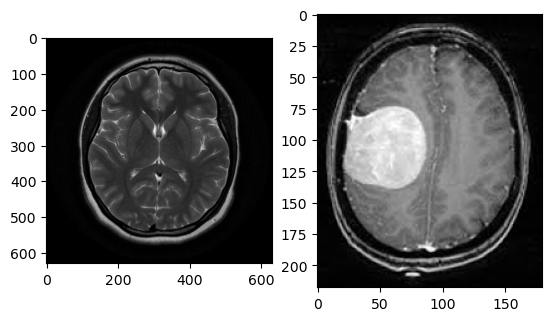

In [12]:
# 使用OpenCV查看圖片
# 灰階組: cv2.IMREAD_GRAYSCALE-灰階
cv2.namedWindow("testImage_BrainTumor")
img_brain = cv2.imread("./brain_tumor_dataset/no/1 no.jpeg",cv2.IMREAD_GRAYSCALE)
img_brain2 = cv2.imread("./brain_tumor_dataset/yes/Y1.jpg",cv2.IMREAD_GRAYSCALE)

fig1 = plt.figure()
plt.subplot(121)
plt.imshow(img_brain,cmap="gray")
plt.subplot(122)
plt.imshow(img_brain2,cmap="gray")
plt.show()
cv2.destroyAllWindows()

In [13]:
# 利用glob套件掃描固定資料夾中副檔名是jpg和png的檔案
# yes file
yes_file_list = glob.glob("brain_tumor_dataset/yes/*.[jJ][pP][gG]") 
yes_file_list.extend(glob.glob("brain_tumor_dataset/yes/*.[pP][nN][gG]"))

# no file
no_file_list = glob.glob("brain_tumor_dataset/no/*.[jJ][pP][gG]")
no_file_list.extend(glob.glob("brain_tumor_dataset/no/*.[pP][nN][gG]"))
no_file_list.extend(glob.glob("brain_tumor_dataset/no/*.[jJ][pP][eE][gG]"))

# 查看張數
yes_file_num = len(yes_file_list)
no_file_num = len(no_file_list)
print("yes共{}筆資料".format(yes_file_num),end="\n")
print("no共{}筆資料".format(no_file_num),end='\n')
print("總共{}筆資料".format(yes_file_num+no_file_num))

yes共155筆資料
no共98筆資料
總共253筆資料


In [15]:
# 讀取所有圖片、resize、轉成ndarray
img_height, img_width = 224,224
yes_data = []
no_data = []
for yes_file in yes_file_list:
    image = cv2.imread(yes_file,cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image,(img_height,img_width))
        image_ndarray = np.array(image)
        yes_data.append(image_ndarray)

for no_file in no_file_list:
    image = cv2.imread(no_file,cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image,(img_height,img_width))
        image_ndarray = np.array(image)
        no_data.append(image_ndarray)

# 確保所有圖片長寬一致
if yes_data:
    first_image_shape = yes_data[0].shape
    print(f"Shape of the yes_data first image: {first_image_shape}, type: {type(yes_data[0])}")
    for image_array in yes_data:
        if image_array.shape != first_image_shape:
            print("yes_data中的圖片shapes不一致")
            break
if no_data:
    first_image_shape = no_data[0].shape
    print(f"Shape of the no_data first image: {first_image_shape}, type: {type(yes_data[0])}")
    for image_array in no_data:
        if image_array.shape != first_image_shape:
            print("no_data中的圖片shapes不一致")
            break
# 轉成 ndarray
yes_array = np.array(yes_data)
no_array = np.array(no_data)
print("yes_array type:{}\nno_array type:{}".format(type(yes_array),type(no_array)))

Shape of the yes_data first image: (224, 224), type: <class 'numpy.ndarray'>
Shape of the no_data first image: (224, 224), type: <class 'numpy.ndarray'>
yes_array type:<class 'numpy.ndarray'>
no_array type:<class 'numpy.ndarray'>
[[[  6   6   6 ...   6   6   6]
  [  6   6   6 ...   6   6   6]
  [  6   6   6 ...   6   6   6]
  ...
  [  6   6   6 ...   6   6   6]
  [  6   6   6 ...   6   7   7]
  [  6   6   6 ...   7   7   8]]

 [[  1   1   1 ...   1   1   1]
  [  1   1   1 ...   1   1   1]
  [  1   1   1 ...   1   1   1]
  ...
  [  1   1   1 ...   1   1   1]
  [  1   1   1 ...   1   1   1]
  [  1   1   1 ...   1   1   1]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 ...

 [[252 255 253 ... 242 253 255]
  [253 252 253 ... 248 254 255]
  [253 247 253 ... 252 253 255]
  ...
  [255 250 252 ... 254 252 255]
  [255 248 254 ... 255 251 255

In [1]:
try:
    !jupyter nbconvert --to python BrainMRI.ipynb
    # python即转化为.py，script即转化为.html
    # file_name.ipynb即当前module的文件名
except:
    pass

[NbConvertApp] Converting notebook BrainMRI.ipynb to python
[NbConvertApp] Writing 3243 bytes to BrainMRI.py
